 # Neural prophet vs ARIMA
 How fast is fitting long AR models using Neural prophet
 In this quick test we will fit AR based models with different lags and see how long they take to fit.

 To start, import some relevant libraries:

In [1]:
from operator import le
from time import process_time, time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("seaborn-whitegrid")

import logging

logging.basicConfig(level=logging.WARNING)

import sys
from pathlib import Path

import statsmodels.tsa.arima.model
from fbprophet import Prophet
from neuralprophet import NeuralProphet

sys.path.insert(0, str(Path(os.getcwd()).parent / "utilities"))
import data
import utilities

ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


 The data used for this experiment is weather data - daily temperatures over a few years with no other covariates.
 We format the data appropriately for the Facebook Prophet API,
 with a datetime column `ds` and an output column `y`.
 We split the data into the usual train and test sets.

,ds,y
0,2009-01-02,-4.54
1,2009-01-03,-4.71
2,2009-01-04,-1.90
3,2009-01-05,-1.47
4,2009-01-06,-12.63
5,2009-01-07,-21.09
6,2009-01-08,-10.78
7,2009-01-09,-13.91
8,2009-01-10,-13.24
9,2009-01-11,-10.75


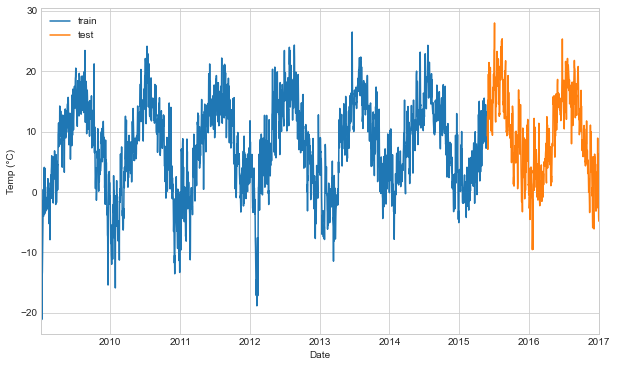

In [2]:
df = data.get_weather_data()
df_train, df_test = utilities.split_ts(df)

ax = df_train["y"].plot(figsize=(10, 6), label="train")
df_test["y"].plot(ax=ax, label="test")
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Temp (°C)")

df_train = df_train.reset_index()
df_test = df_test.reset_index()

df_train.head(10)

 Now let's fit two sets of models. The first is an ARIMA model from `statsmodels` the second is an approximate AR model using `NeuralProphet`.
 Each iteration we increase the number of lags used in the model, and we time how long each takes to fit.
 The neural prophet model has the various seasonalities and change point parts disabled so it closer to a raw AR model.

In [3]:
fit_time_ar = []
fit_time_np = []
mae_np = []
lag_range = range(1,25)
logging.getLogger("nprophet").setLevel(logging.WARNING)
for lag in lag_range:
    # fit statsmodels
    t1 = process_time()
    model_arima = statsmodels.tsa.arima.model.ARIMA(endog=df_train.set_index('ds'), order=(lag,0,0), freq='1D').fit()
    fit_time_ar.append(process_time() - t1)

    # fit neuralprophet
    t1 = process_time()
    model_nprophet_ar = NeuralProphet(
        growth="off",
        n_changepoints=0,
        n_forecasts=1,
        n_lags=lag,
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=False,
    )
    mae_np.append(model_nprophet_ar.fit(df_train, freq="D"))
    fit_time_np.append(process_time() - t1)

/Users/Rich/Developer/miniconda3/envs/neural_prophet_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
100%|██████████| 100/100 [00:00<00:00, 579.28it/s]
/Users/Rich/Developer/miniconda3/envs/neural_prophet_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 92%|█████████▏| 92/100 [00:00<00:00, 608.31it/s]
/Users/Rich/Developer/miniconda3/envs/neural_prophet_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 93%|█████████▎| 93/100 [00:00<00:00, 519.62it/s]
/Users/Rich/Developer/miniconda3/envs/neural_prophet_env/lib/py

 Plotting these results we can see that the fitting time for neuralprophet is fairly flat.
 As expected with fitting ARIMA models, the time of fitting increases rapidly with the number of lags.
 This means neuralprophet allows us to fit longer AR based models which would not be otherwise possible.

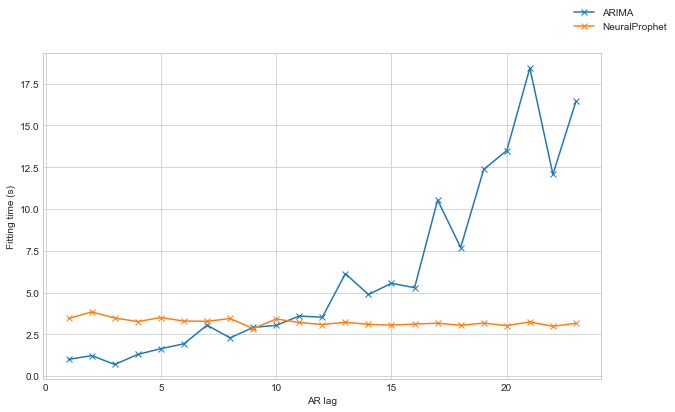

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(lag_range[:-1], fit_time_ar[:-1], '-x',label='ARIMA')
ax.plot(lag_range[:-1], fit_time_np[:-1], '-x',label='NeuralProphet')
fig.legend()
ax.set_xlabel('AR lag')
ax.set_ylabel('Fitting time (s)')
plt.show()

 As such we can fit models with significantly longer lags.
 This may not be necessary most of the time, but if we wanted to, we could do it!

In [5]:
lag = 300
t1 = process_time()
logging.getLogger("nprophet").setLevel(logging.INFO)
model_nprophet_ar = NeuralProphet(
    growth="off",
    n_changepoints=0,
    n_forecasts=1,
    n_lags=lag,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    epochs = 100
)
loss_epoch = model_nprophet_ar.fit(df_train, freq="D")
print("\n")
print("\n")
print(f"Time taken: {process_time() - t1} s")

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
 84%|████████▍ | 84/100 [00:00<00:00, 782.63it/s]
INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-02
INFO:nprophet:learning rate range test found optimal lr: 2.85E-02
Epoch[100/100]: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s, SmoothL1Loss=0.00179, MAE=2.23, RegLoss=0]




Time taken: 9.842839999999995 s


 Neuralprophet is based on an underlying pytorch model and trains using gradient descent.
 The fitting time is related to the number of epochs. This is chosen automatically in the package.
 The learning rate is by default chosen with pytorch lightning's learning rate finder.
 The automatic learning rate can be a bit noisy and stop training early.
 As such it may be necessary to plot the loss against epoch.
 As a single example, the auto epoch number would be 27 in the following graph, where we train for 100.

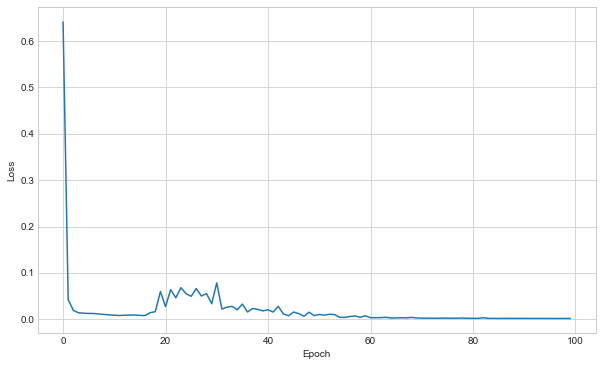

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(loss_epoch['SmoothL1Loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

 Even though, we can train for much more epochs and still successfully train a very long AR model.

 ## Prediction results
 The models will not be identical. We can train a smaller AR model and inspect it's coefficients:

In [7]:
lag = 5
model_arima = statsmodels.tsa.arima.model.ARIMA(endog=df_train.set_index('ds'), order=(lag,0,0), freq='1D').fit()

# fit neuralprophet
model_nprophet_ar = NeuralProphet(
    growth="off",
    n_changepoints=0,
    n_forecasts=1,
    n_lags=lag,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    epochs = 100
)
model_nprophet_ar.fit(df_train, freq="D")

/Users/Rich/Developer/miniconda3/envs/neural_prophet_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
100%|██████████| 100/100 [00:00<00:00, 666.78it/s]
INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[100/100]: 100%|██████████| 100/100 [00:10<00:00,  9.88it/s, SmoothL1Loss=0.002, MAE=2.35, RegLoss=0]


,SmoothL1Loss,MAE,RegLoss
0,0.183347,21.514868,0.0
1,0.006181,4.135442,0.0
2,0.003016,2.880831,0.0
3,0.002606,2.692866,0.0
4,0.002437,2.604848,0.0
...,...,...,...
95,0.002067,2.387542,0.0
96,0.002079,2.405267,0.0
97,0.002022,2.359091,0.0
98,0.002015,2.369480,0.0


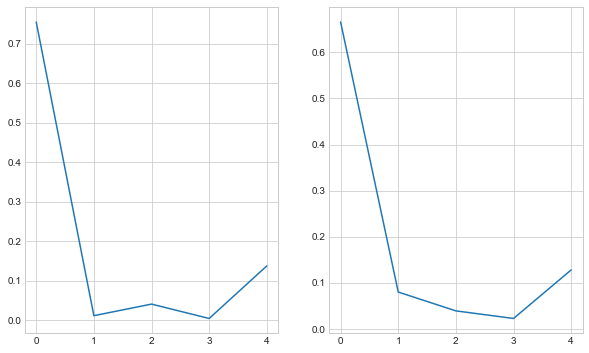

In [8]:
fig, ax = plt.subplots(figsize=(10,6), ncols=2)
ax[0].plot(model_arima.params.iloc[1:-1].to_numpy(), label='ARIMA')
ax[1].plot(np.flip(model_nprophet_ar.model.ar_weights.detach().numpy()).flatten(), label='np')
plt.show()

 Their coefficients differ slightly.
 This in turn causes their predictions to be slightly different:

<AxesSubplot:xlabel='ds'>

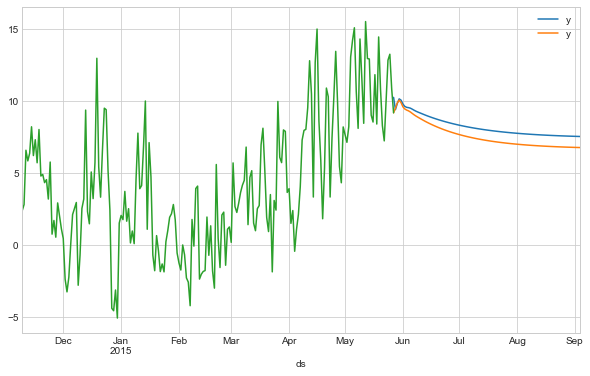

In [9]:
pred_arima = model_arima.predict(start=df_train['ds'].iloc[-1], end=df_train['ds'].iloc[-1] + pd.Timedelta('100D'))

pred_nprophet = df_train.copy()
for idx in range(100):
    future_nprophet = model_nprophet_ar.make_future_dataframe(
        df=pred_nprophet,
    )
    temp = model_nprophet_ar.predict(future_nprophet)
    temp['y'] = temp[['y','yhat1']].fillna(0).sum(axis=1)
    temp = temp[['ds','y']]
    pred_nprophet = pred_nprophet.append(temp.iloc[-1])
pred_nprophet = pred_nprophet.iloc[-101:].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))
pred_arima.plot(ax=ax, label='ARIMA')
pred_nprophet.set_index('ds').plot(ax=ax, label='np')
df_train.set_index('ds').iloc[-200:].plot(ax=ax)